# Evaluate how Number of Codes affects Predictive Power

In [1]:
import os, sys
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import glob 
import pickle 

# from scipy.interpolate import interp1d
# from cycler import cycler
import xgboost as xgb
from collections import OrderedDict 

from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
from IPython.core.display import display, HTML    
display(HTML("<style>.container {width:98% !important; }</style>"))
%matplotlib inline
np.set_printoptions(precision=5, suppress=True) 

DATE = datetime.now().strftime('%Y-%m-%d')

In [2]:
from scipy import stats

In [3]:
sys.path.append('/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/scripts/rand_forest_ptb_classification')
from hyperparam_tune import validate_best_model

In [4]:
sys.path.append("/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/scripts/rand_forest_ptb_classification/manuscript/0_helper_func")
from manip_trained_models_funcs import unpack_input_data, upickle_xgbmodel, extract_train_df, extract_test_df

In [5]:
%load_ext rpy2.ipython

In [6]:
ROOT_DATA_DIR = "/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/results/ptb_predict_machine_learning/2019-02-02_manuscript_time_to_delivery_icd_cpt/without_age_race_count" 
OUTPUT_DIR = "/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/scripts/rand_forest_ptb_classification/manuscript/time_to_delivery"

# Functions

In [7]:
def get_test_performance(input_file, model_file):
    
    
    input_data = pd.read_csv(input_file, sep="\t")
    print("done loading {}".format(os.path.basename(input_file)))
    
    held_out_df = input_data.loc[input_data['partition']=='held_out'].copy()
    train_df = input_data.loc[input_data['partition']=='grid_cv'].copy()
    held_out_df.set_index('GRID',inplace=True)
    train_df.set_index('GRID',inplace=True)
    
    X_test = held_out_df.iloc[:,:-2]
    y_test = held_out_df.label.apply(lambda x: 1 if x == 'preterm' else 0).values

    
    xgb_model = pickle.load(open(model_file, "rb"))
    
    return X_test, y_test, xgb_model 

In [8]:
def plot_roc(store_fpr, store_tpr, aucs, plt_prefix='', roc_fig_file=None):
    '''
    plot auroc curve(s) with mean and std; save if a roc_fig_file is provided

        INPUTS:
            * store_fpr, store_tpr, aucs: a list where each element represents data for one curve
            * plt_prefix: label to add to the title of plot
            * roc_fig_file: full path to save file
            * savefig: boolean to save or not save figure

        note: first three must be a list; will not plot mean and std if only one curve
    '''
    print("Creating roc plot.....")

    interp_fpr = np.linspace(0, 1, 100)
    store_tpr_interp = []

    ax = plt.figure()
    plt.plot([0, 1], [0, 1], linestyle='--', lw=4, color='r', label='Chance', alpha=.8)

    # plot each cv iteration
    for cv_iter, fpr_tpr_auc in enumerate(zip(store_fpr, store_tpr, aucs)):
        # set_trace()
        fpr, tpr, auc = fpr_tpr_auc
        plt.plot(fpr, tpr, lw=4, alpha=0.9, label="#{}(AUC={:.3f})".format(cv_iter, auc))

        lin_fx = interp1d(fpr, tpr, kind='linear')
        interp_tpr = lin_fx(interp_fpr)

        # store_tpr_interp.append(np.interp(mean_fpr, fpr, tpr))
        # store_tpr_interp[-1][0] = 0.0
        store_tpr_interp.append(interp_tpr)

    # plot mean and std only if more than one curve present
    if len(store_fpr) != 1:
        # plot mean, sd, and shade in between
        mean_tpr = np.mean(store_tpr_interp, axis=0)
        # mean_tpr[-1] = 1.0
        mean_auc = metrics.auc(interp_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(interp_fpr, mean_tpr, color='b',
                 label="Mean(AUC={:.2f}+/-{:.2f})".format(mean_auc, std_auc),
                 lw=2, alpha=.8)

        std_tpr = np.std(store_tpr_interp, axis=0)
        tprs_upper = np.minimum(mean_tpr + 2*std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - 2*std_tpr, 0)
        plt.fill_between(interp_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label="+/- 2 S.D.")

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for {}:\nPrediting PTB vs. non-PTB'.format(plt_prefix))
    plt.legend(loc="lower right")

    if roc_fig_file:
        plt.savefig(roc_fig_file)
        print("\tDone. AUROC curve saved to:\n\t{}".format(roc_fig_file))

    return ax

In [9]:
def plot_pr(precisions, recalls, avg_prs, plt_prefix, pr_fig_file=None, pos_prop=None):
    ''' plot PR curve(s) with mean and std; save if pr_fig_file is provided

        INPUTS:
            * precisions, recalls, avg_prs: must be a list where each element represents data for one curve
            * plt_prefix: label to add to the title of plot
            * pr_fig_file: full path to save file
            * pos_prop: total true positives / total samples (i.e. proportion of positves)

        note: first three must be a list; will not plot mean and std if only one curve
    '''
    print("Creating PR curve plot ...")
    # mean_rc = np.linspace(0, 1, 100)
    interp_rc = np.linspace(0, 1, 100)

    store_pr_interp = []
    ax = plt.figure()

    # plot line of random chance
    if pos_prop:
        plt.plot([0, 1], [pos_prop, pos_prop], linestyle='--', lw=4,
                 color='r', label='Chance({:.3f})'.format(pos_prop), alpha=.8)

    # plot each cv_iter
    for cv_iter, pr_rc_avg in enumerate(zip(precisions, recalls, avg_prs)):

        pr_array, rc_array, pr_avg = pr_rc_avg
        # plt.plot(rc_array, pr_array, lw=1, color='k', alpha=0.4)
        plt.step(rc_array, pr_array, lw=4, alpha=0.8, where='post', label="#{}(AvgPR={:.3f})".format(cv_iter, pr_avg))

        # interpolate recall to have the same length array for taking mean
        lin_fx = interp1d(rc_array, pr_array, kind='linear')
        interp_pr = lin_fx(interp_rc)
        store_pr_interp.append(interp_pr)

    # set_trace()

    # plot mean and std only if more than one curve present
    if len(precisions) != 1:
        # mean and std
        mean_pr = np.mean(store_pr_interp, axis=0)
        mean_avg_pr = np.mean(avg_prs)
        std_avg_pr = np.std(avg_prs)

        # std of each pr-curve
        std_pr = np.std(store_pr_interp, axis=0)
        pr_upper = np.minimum(mean_pr + 2*std_pr, 1)
        pr_lower = np.maximum(mean_pr - 2*std_pr, 0)
        plt.fill_between(interp_rc, pr_lower, pr_upper, color='grey', alpha=.2,
                         label="+/- 2 S.D.")

        plt.plot(interp_rc, mean_pr, color='b',
                 label="Mean(AUC={:.2f}+/-{:.2f})".format(mean_avg_pr, std_avg_pr), lw=2, alpha=0.8)

    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR Curve for {}:\nPrediting PTB vs. non-PTB'.format(plt_prefix))
    plt.legend(loc="lower right")

    if pr_fig_file:
        plt.savefig(pr_fig_file)
        print("\tPR curve saved to:\n\t{}".format(pr_fig_file))

    return ax

In [10]:
def classifier(feat_df_og, y_test):
    feat_df = feat_df_og.copy()
    
    # add y label
    feat_df['label_temp'] = y_test
    feat_df['label'] = feat_df.label_temp.apply(lambda x: 'preterm' if x ==1 else 'not-preterm')
    feat_df.drop('label_temp', axis=1, inplace=True)

    
    feat_df['total_code_count'] = feat_df.sum(1)

    ### set up thresholds 
    classify_values = feat_df.total_code_count.values
    num_thresholds = 1000
    tot_thres =  (np.max(classify_values)+1) - np.min(classify_values) 
    thresholds = np.arange(np.min(classify_values), (np.max(classify_values)+1), tot_thres/num_thresholds)

    ### calc confusion matrix 
    tprs, fprs, prs, rcs = [],[],[],[]
    actual_neg = feat_df.loc[ feat_df['label'] != 'preterm'].shape[0]
    actual_pos = feat_df.loc[ feat_df['label'] == 'preterm'].shape[0]
    for ind, thresh in enumerate(thresholds): 
        print(ind) if ((ind %100) == 0)  else None
        # calc TP, TN, FP, FN 

        pos_label = 'preterm' 

        tp = feat_df.loc[ (feat_df['total_code_count'] >= thresh) & (feat_df['label'] == 'preterm')].shape[0]
        fp = feat_df.loc[ (feat_df['total_code_count'] >= thresh) & (feat_df['label'] != 'preterm')].shape[0]


        fn = feat_df.loc[ (feat_df['total_code_count'] < thresh) & (feat_df['label'] == 'preterm')].shape[0]
        tn = feat_df.loc[ (feat_df['total_code_count'] < thresh) & (feat_df['label'] != 'preterm')].shape[0]
#         fp = actual_neg - tn
#         tp = actual_pos - fn

        fpr = fp/(tn+fp+0.001) 
        tpr = tp/(tp+fn+0.001)
        pr = tp/(tp+fp+0.001)
        rc = tp/(tp+fn+0.001)


        tprs.append(fpr)
        fprs.append(tpr)
        prs.append(pr)
        rcs.append(rc)
    
    return  tprs, fprs, prs, rcs, thresholds

In [11]:
def prep_for_auc(fprs, tprs, prs, rcs, thresholds):
    
    # sort fpr and recall
    sorted_ind = np.argsort(fprs)
    sorted_ind_recall = np.argsort(rcs)
    
    sorted_fprs = [fprs[x] for x in sorted_ind]
    sorted_tprs = [tprs[x] for x in sorted_ind]
    sorted_recall = [rcs[x] for x in sorted_ind_recall]
    sorted_precision =[prs[x] for x in sorted_ind_recall]
    sorted_thresholds =[thresholds[x] for x in sorted_ind_recall]
    # calc auc 
    auc = np.trapz(sorted_tprs,sorted_fprs)
    pr_auc = np.trapz(sorted_precision, sorted_recall)
    
    return sorted_fprs, sorted_tprs, sorted_recall, sorted_precision, sorted_thresholds

In [12]:
def calc_auc(sorted_tprs, sorted_fprs,sorted_precision, sorted_recall): 
    auc = np.trapz(sorted_tprs,sorted_fprs)
    pr_auc = np.trapz(sorted_precision, sorted_recall)
    
    return auc, pr_auc

In [13]:
def plot_roc(sorted_fprs, sorted_tprs, auc, plt_title, sorted_threshold=None):
    fig, ax = plt.subplots()
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    plt.plot(sorted_fprs, sorted_tprs, lw=3,label='AUC={:.3f}'.format(auc))
    
    if sorted_threshold: 
        norm_thres = sorted_threshold/np.max(sorted_threshold)
        plt.plot(sorted_fprs, norm_thres,  '--k',lw=1, label='threshold')
    _ = ax.set_ylabel('TPR')
    _ = ax.set_xlabel('FPR')
    _ = ax.set_title('ROC: {}'.format(plt_title))
    _ = ax.set(xlim=(0,1), ylim=(0,1))
    plt.legend(loc='best')
    
    return ax 

In [14]:
def plot_pr(sorted_recall, sorted_precision, pr_auc, plt_title,sorted_threshold=None, chance=None):

    fig, ax = plt.subplots()

    plt.plot(sorted_recall, sorted_precision,lw=3, label='AVG-PR={:.3f}'.format(pr_auc))

    if chance: 
        plt.plot([0, 1], [chance, chance], linestyle='--', lw=2, color='r', label='Chance(AUC={})'.format(chance), alpha=.8)
    
    if sorted_threshold: 
        norm_thres = sorted_threshold/np.max(sorted_threshold)
        plt.plot(sorted_fprs, norm_thres,  '--k',lw=1, label='threshold')
    _ = ax.set_ylabel('Preicsion')
    _ = ax.set_xlabel('Recall')
    _ = ax.set_title('PR: {}'.format(plt_title))
    _ = ax.set(xlim=(0,1), ylim=(0,1))
    plt.legend(loc='best')
    
    return ax 

In [15]:
def creat_count_df(xgb_model, X_test, y_test):
    bin_X_test = X_test.applymap(lambda x: 1 if x > 1 else 0)
    
    y_test_proba = xgb_model.predict_proba(X_test)
    y_test_pred = xgb_model.predict(X_test)
    x_test_scount= X_test.sum(1).values
    x_test_uniq_count= bin_X_test.sum(1).values
    log_x_test_scount= bin_X_test.sum(1).values

    cor_df = pd.DataFrame({'y_test':y_test, 'y_test_pred':y_test_pred, 'y_test_proba_1':y_test_proba[:,1], 
                          'x_test_scount':x_test_scount, 'x_test_uniq_count':x_test_uniq_count})

    cor_df['log_x_test_scount'] = cor_df.x_test_scount.apply(lambda x: np.log10(x))
    
    return cor_df

In [16]:
def plot_code_violins(cor_df, y1,y2): 
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

    sns.violinplot(x="y_test", y=y1, data=cor_df, scale='width', ax=ax[0])
    sns.violinplot(x="y_test", y=y2, data=cor_df, scale='width',ax=ax[1])

    _ , pval = stats.ks_2samp(cor_df.loc[cor_df['y_test']==1,y1],
                   cor_df.loc[cor_df['y_test']==0,y1])


    _ , pval_log = stats.ks_2samp(cor_df.loc[cor_df['y_test']==1,y2],
                   cor_df.loc[cor_df['y_test']==0,y2])

    _ = ax[0].set_xlabel('True Label\n(1=preterm,0=not-preterm)')
    _ = ax[1].set_xlabel('True Label\n(1=preterm,0=not-preterm)')
#     _ = ax[0].set_ylabel('Sum of All ICD-9/CPT Counts')
#     _ = ax[1].set_ylabel('log10 (Sum of All ICD-9/CPT Counts)')
    ypos_= ax[0].get_ylim()[1] - ax[0].get_ylim()[1]*.05
    ypos_log= ax[1].get_ylim()[1] - ax[1].get_ylim()[1]*.05
    _ = ax[0].text(1.1,ypos_,'K-S\n(p={:.2E})'.format(pval), color='r', size=14)
    _ = ax[1].text(1.1,ypos_log,'K-S\n(p={:.2E})'.format(pval_log), color='r', size=14)
    sns.despine(left=True)
    plt.tight_layout()
    
    return ax

# Raw Counts ICD & CPT 

## Load Data 

In [17]:
# load all up_to_ file names
up_to_dataset_dict = OrderedDict()
for num_days in ['0','10','90', '273','365']: 
            
    input_file = glob.glob(ROOT_DATA_DIR+'/up_to_*_days/input_data_up_to_{}_days*'.format(num_days))[0]
    model_file = glob.glob(ROOT_DATA_DIR+'/up_to_*_days/best_xgb_model_up_to_{}_days*.pickle'.format(num_days))[0]

    up_to_dataset_dict['{}_days'.format(num_days)] =  {'input_file': input_file, 'model_file': model_file}


# main

In [18]:
timepoint='0_days'

In [19]:
X_train, y_train, X_test, y_test, xgb_model, input_data = unpack_input_data(up_to_dataset_dict[timepoint]['input_file'], up_to_dataset_dict[timepoint]['model_file'])
bin_X_test = X_test.applymap(lambda x: 1 if x > 1 else 0)

loading input_data_up_to_0_days_before_delivery_icd9_cpt_count-2019-02-16.tsv ...
loading best_xgb_model_up_to_0_days_before_delivery_icd9_cpt_count-2019-02-16.pickle ...
done loading. took 1.75 minutes


/dors/capra_lab/users/abraha1/conda/envs/py36_r_ml/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.20.1 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [20]:
cor_df = creat_count_df(xgb_model, X_test, y_test)

# plot total code count distribution

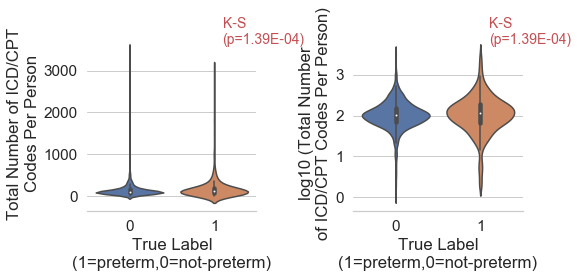

In [324]:
ax = plot_code_violins(cor_df, 'x_test_scount','log_x_test_scount')
_ = ax[0].set_ylabel('Total Number of ICD/CPT\nCodes Per Person')
_ = ax[1].set_ylabel('log10 (Total Number\nof ICD/CPT Codes Per Person)')
# plt.savefig(os.path.join(OUTPUT_DIR, '{}_{}_violin_total_code_dist.png'.format(DATE, timepoint)))

# train classifier

In [325]:
tprs, fprs, prs, rcs, thresholds = classifier(X_test, y_test)
sorted_fprs, sorted_tprs, sorted_recall, sorted_precision, sorted_thresholds = prep_for_auc(fprs, tprs, prs, rcs, thresholds)
auc, pr_auc = calc_auc(sorted_tprs, sorted_fprs,sorted_precision, sorted_recall)

0
100
200
300
400
500
600
700
800
900


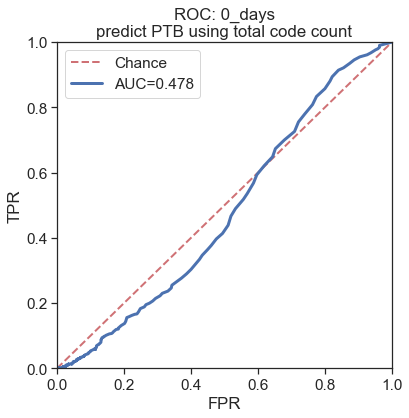

In [326]:
sns.set(style='ticks',rc={'figure.figsize':(6,6)}, font_scale=1.4)
plot_roc(sorted_fprs, sorted_tprs, auc, '{}\npredict PTB using total code count'.format(timepoint))
# plt.savefig(os.path.join(OUTPUT_DIR, '{}_{}_roc_total_code.png'.format(DATE, timepoint)))

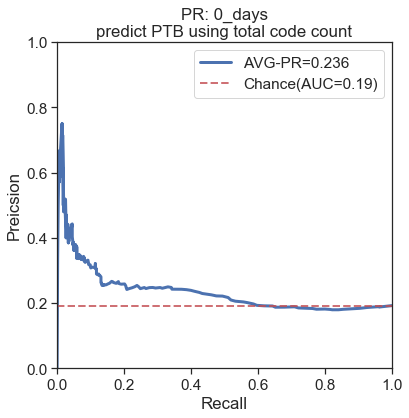

In [327]:
sns.set(style='ticks',rc={'figure.figsize':(6,6)}, font_scale=1.4)
pr_chance= np.round(np.sum(y_test)/len(y_test),2)
plot_pr(sorted_recall, sorted_precision,pr_auc, '{}\npredict PTB using total code count'.format(timepoint), chance=pr_chance)
plt.savefig(os.path.join(OUTPUT_DIR, '{}_{}_pr_auc_total_code.png'.format(DATE, timepoint)))

# timepoint =  90 days

In [313]:
timepoint='90_days'

In [314]:
X_train, y_train, X_test, y_test, xgb_model, input_data = unpack_input_data(up_to_dataset_dict[timepoint]['input_file'], up_to_dataset_dict[timepoint]['model_file'])
bin_X_test = X_test.applymap(lambda x: 1 if x > 1 else 0)

loading input_data_up_to_90_days_before_delivery_icd9_cpt_count-2019-02-16.tsv ...
loading best_xgb_model_up_to_90_days_before_delivery_icd9_cpt_count-2019-02-16.pickle ...
done loading. took 1.57 minutes


/dors/capra_lab/users/abraha1/conda/envs/py36_r_ml/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.20.1 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [315]:
cor_df = creat_count_df(xgb_model, X_test, y_test)

# plot total code count distribution

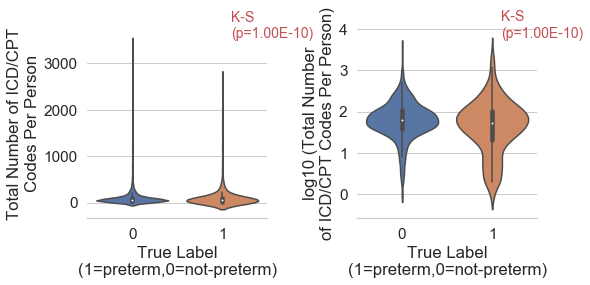

In [317]:
ax = plot_code_violins(cor_df, 'x_test_scount','log_x_test_scount')
_ = ax[0].set_ylabel('Total Number of ICD/CPT\nCodes Per Person')
_ = ax[1].set_ylabel('log10 (Total Number\nof ICD/CPT Codes Per Person)')
# plt.savefig(os.path.join(OUTPUT_DIR, '{}_{}_violin_total_code_dist.png'.format(DATE, timepoint)))

# train classifier

In [318]:
tprs, fprs, prs, rcs, thresholds = classifier(X_test, y_test)
sorted_fprs, sorted_tprs, sorted_recall, sorted_precision, sorted_thresholds = prep_for_auc(fprs, tprs, prs, rcs, thresholds)
auc, pr_auc = calc_auc(sorted_tprs, sorted_fprs,sorted_precision, sorted_recall)

0
100
200
300
400
500
600
700
800
900


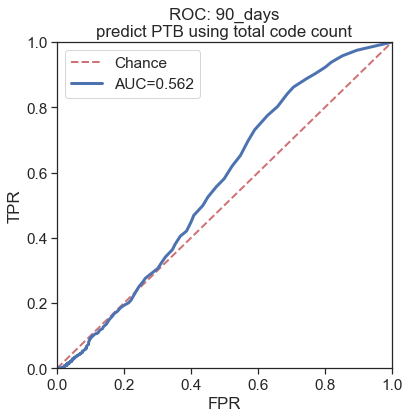

In [319]:
sns.set(style='ticks',rc={'figure.figsize':(6,6)}, font_scale=1.4)
plot_roc(sorted_fprs, sorted_tprs, auc, '{}\npredict PTB using total code count'.format(timepoint))
plt.savefig(os.path.join(OUTPUT_DIR, '{}_{}_roc_total_code.png'.format(DATE, timepoint)))

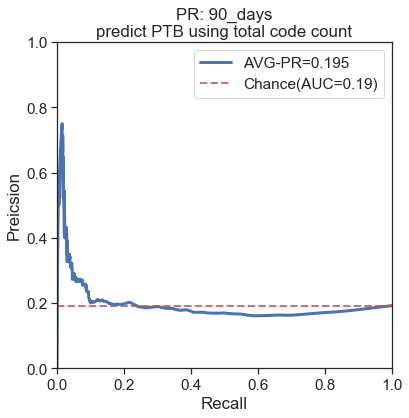

In [320]:
sns.set(style='ticks',rc={'figure.figsize':(6,6)}, font_scale=1.4)
pr_chance= np.round(np.sum(y_test)/len(y_test),2)
plot_pr(sorted_recall, sorted_precision,pr_auc, '{}\npredict PTB using total code count'.format(timepoint), chance=pr_chance)
plt.savefig(os.path.join(OUTPUT_DIR, '{}_{}_pr_auc_total_code.png'.format(DATE, timepoint)))